## 이미지 다운로드

In [ ]:
!mkdir -p ~/work/aiffel_quest_rs/Exploration/Ex01/images
!mkdir -p ~/work/aiffel_quest_rs/Exploration/Ex01/models
!cd ~/work/aiffel_quest_rs/Exploration/Ex01/

In [ ]:
!wget https://d3s0tskafalll9.cloudfront.net/media/images/E-8-6.max-800x600_rkMHa4K.png # 기본 제공 이미지입니다. 여러분만의 이미지로 수정해보세요!
!mv E-8-6.max-800x600_rkMHa4K.png ./images/image.png

In [ ]:
!wget https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-3.png
!wget https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-4.png

!mv E-8-3.png ./images/king.png
!mv E-8-4.png ./images/hero.png

## 패키지 다운로드

In [ ]:
!pip install cmake opencv-python
!conda install -y dlib

## Dlib의 제공되는 모델

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ./models
!cd ./ && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

## 패키지 선언
- import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
- import cv2: OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
- import matplotlib.pyplot as plt: 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
- import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
- import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리


In [1]:
import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import dlib 
import math

## FaceStickerProcessor 클래스 정의
- ### init: 얼굴 검출기 및 특징점 예측기 초기화
- ### get_angle: 양쪽 눈의 중앙점을 기준으로 얼굴의 기울기 각도를 계산
- ### rotate_image: 스티커 이미지를 얼굴 각도만큼 회전
- ### calculate_roi: 이미지 경계를 벗어나는 스티커 영역을 계산하여 자르기
- ### get_sticker_coords: 특징점 데이터를 기반으로 스티커의 왼쪽 상단 시작점을 결정
- ### _get_cleaned_mask: 스티커 전체 이미지에 대해 외곽 흰색/투명 배경을 정리
- ### apply_sticker :선택된 스티커를 특정 위치에 마스킹 기법을 사용하여 합성
- ### get_steps : 다중 얼굴 데이터를 받아 시각화 단계 생성
- ### show_comparison_pipeline: 전체 프로세스를 실행하고 matplotlib을 통해 단계별 결과를 한눈에 비교 출력

In [2]:
class FaceStickerProcessor:
    # 랜드마크 인덱스 정의 (68 points 기준)
    LANDMARK_NOSE_TIP = 30
    LANDMARK_CHIN = 8
    LEFT_EYE_RANGE = range(36, 42)
    RIGHT_EYE_RANGE = range(42, 48)
    
    def __init__(self, model_path):
        """ 얼굴 검출기 및 특징점 예측기 초기화 """
        self.detector = dlib.get_frontal_face_detector()
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
        self.predictor = dlib.shape_predictor(model_path)
        
    def load_image(self, img_path):
        img_bgr = cv2.imread(img_path)
        if img_bgr is None: 
            raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
        return img_bgr

    def _get_angle(self, landmarks):
        """ 양쪽 눈의 중앙점을 기준으로 얼굴의 기울기 각도를 계산 """
        # 왼쪽 눈과 오른쪽 눈의 중앙점(mean) 구하기
        l_eye = np.mean([landmarks[i] for i in self.LEFT_EYE_RANGE], axis=0)
        r_eye = np.mean([landmarks[i] for i in self.RIGHT_EYE_RANGE], axis=0)
        
        dy = r_eye[1] - l_eye[1]
        dx = r_eye[0] - l_eye[0]
        
        # 아크탄젠트를 사용하여 각도(degree) 계산
        angle = math.degrees(math.atan2(dy, dx))
        return angle

    def _rotate_image(self, image, angle):
        """스티커 이미지를 얼굴 각도만큼 회전"""
        h, w = image.shape[:2]
        center = (w // 2, h // 2)

        # 이미지가 3채널(BGR)이면 4채널(BGRA)로 변환하여 투명도 채널 추가
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
        
        # 회전 행렬 생성 (scale=1.0)
        matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        # 회전 적용 (빈 공간은 검은색/투명 처리)
        rotated = cv2.warpAffine(image, matrix, (w, h),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(0,0,0,0))
        return rotated

    def draw_rotated_rect(self, img, rect, angle, color=(0, 255, 0), thickness=3):
        """사각형을 각도에 맞춰 회전시켜 그리는 함수"""
        x, y, w, h = rect.left(), rect.top(), rect.width(), rect.height()
        center = (x + w // 2, y + h // 2)
        
        # 사각형의 네 꼭짓점 좌표
        points = np.array([
            [x, y],
            [x + w, y],
            [x + w, y + h],
            [x, y + h]
        ])
        
        # 회전 행렬 구하기
        rot_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        
        # 각 꼭짓점을 회전 이동 시킴
        rotated_points = cv2.transform(np.array([points]), rot_matrix)[0]
        
        # 회전된 꼭짓점들을 선으로 연결하여 사각형 그리기
        for i in range(4):
            pt1 = tuple(rotated_points[i].astype(int))
            pt2 = tuple(rotated_points[(i + 1) % 4].astype(int))
            cv2.line(img, pt1, pt2, color, thickness)
        return img
    
    def _calculate_roi(self, img_shape, x, y, w, h):
        """ 이미지 경계를 벗어나는 스티커 영역을 계산하여 자르기 """
        img_h, img_w = img_shape[:2]
        
        # 대상 이미지 내의 유효 범위 계산
        y1, y2 = max(0, y), min(img_h, y + h)
        x1, x2 = max(0, x), min(img_w, x + w)
        
        # 스티커에서의 좌표 계산 - 배경을 벗어난 만큼 스티커도 잘라내야 하므로 음수 좌표만큼 오프셋 적용
        sy1, sx1 = max(0, -y), max(0, -x)
        sy2, sx2 = sy1 + (y2 - y1), sx1 + (x2 - x1)
        
        return (y1, y2, x1, x2), (sy1, sy2, sx1, sx2)

    def _get_sticker_coords(self, sticker_type, rect, landmarks, w, h):
        """ 특징점 데이터를 기반으로 스티커의 왼쪽 상단 시작점을 결정 """
        if sticker_type == 'hero':
            # 턱 위치 중심
            x_ref, y_ref = landmarks[self.LANDMARK_CHIN]
            return x_ref - w // 2, y_ref - h // 2
            
        elif sticker_type == 'king':
            # 코 끝 기준, 얼굴 위쪽으로 배치
            x_ref, y_ref = landmarks[self.LANDMARK_NOSE_TIP]
            return x_ref - w // 2, y_ref - rect.height() // 2 - h
            
        else: # 'cat' 또는 기본값
            # 코 끝 중심
            x_ref, y_ref = landmarks[self.LANDMARK_NOSE_TIP]
            return x_ref - w // 2, y_ref - h // 2
            
    def _get_cleaned_mask(self, sticker_img):
        """ 스티커 전체 이미지에 대해 외곽 흰색/투명 배경을 정리합니다. """
        # 알파 채널 및 RGB 분리
        if sticker_img.shape[2] == 4:
            alpha = sticker_img[:, :, 3].copy()
            rgb = sticker_img[:, :, :3].copy()
        else:
            alpha = np.ones(sticker_img.shape[:2], dtype=np.uint8) * 255
            rgb = sticker_img.copy()

        h, w = rgb.shape[:2]
        gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

        # 배경 제거용 마스크 생성 (흰색 영역 + 이미 투명한 영역)
        _, white_mask = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY)
        
        # 이미 투명한 부분(alpha=0)도 배경으로 합침
        combined_bg = cv2.bitwise_or(white_mask, cv2.bitwise_not(alpha))

        # FloodFill로 '외곽과 연결된' 배경만 추출
        flood_mask = np.zeros((h + 2, w + 2), np.uint8)
        out_mask = combined_bg.copy()
        
        # 네 변의 모든 테두리에서 floodFill 시도
        for x in range(0, w, 5):
            for y in [0, h-1]:
                if out_mask[y, x] == 255:
                    cv2.floodFill(out_mask, flood_mask, (x, y), 0)
        for y in range(0, h, 5):
            for x in [0, w-1]:
                if out_mask[y, x] == 255:
                    cv2.floodFill(out_mask, flood_mask, (x, y), 0)

        # 최종 알파 채널 결정
        # (원래 흰색이었던 부분) - (외곽과 연결되지 않아 살아남은 부분) = 제거할 배경
        actual_bg = cv2.subtract(combined_bg, out_mask)
        alpha = cv2.bitwise_and(alpha, cv2.bitwise_not(actual_bg))
        
        return alpha
    
    
    def apply_sticker(self, img_original, rect, landmarks, sticker_path, sticker_type='king'):
        """ 선택된 스티커를 특정 위치에 마스킹 기법을 사용하여 합성 """
        img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
        if img_sticker is None: 
            return img_original.copy()
        
        # 얼굴 크기(rect.width)에 맞춰 스티커 크기 조절
        w = h = rect.width()
        img_sticker = cv2.resize(img_sticker, (w, h))

        # 합성 전 '전체 스티커'에서 배경 제거 마스크 추출
        cleaned_alpha = self._get_cleaned_mask(img_sticker)
        img_sticker = cv2.merge([img_sticker[:,:,0], img_sticker[:,:,1], img_sticker[:,:,2], cleaned_alpha])
        
        # 각도 계산 및 스티커 회전 (추가된 부분)
        angle = self._get_angle(landmarks)
        img_sticker = self._rotate_image(img_sticker, angle)
        
        # 좌표 및 ROI 계산 (이미지 밖으로 나가는 예외 처리 포함)
        refined_x, refined_y = self._get_sticker_coords(sticker_type, rect, landmarks, w, h)
        target_roi, source_roi = self._calculate_roi(img_original.shape, refined_x, refined_y, w, h)
        y1, y2, x1, x2 = target_roi
        sy1, sy2, sx1, sx2 = source_roi

        if (y2 - y1) <= 0 or (x2 - x1) <= 0:
            return img_original.copy()

        # 알파 블렌딩
        img_result = img_original.copy()
        sticker_crop = img_sticker[sy1:sy2, sx1:sx2]
        canvas_crop = img_result[y1:y2, x1:x2]
        
        alpha_mask = sticker_crop[:, :, 3] / 255.0
        for c in range(3):
            img_result[y1:y2, x1:x2, c] = (
                alpha_mask * sticker_crop[:, :, c] + 
                (1.0 - alpha_mask) * canvas_crop[:, :, c]
            )
            
        return img_result

    def get_steps(self, img_bgr, rects, all_landmarks, sticker_configs):
        """ 다중 얼굴 데이터를 받아 시각화 단계 생성 """
        # Step 0: Original
        step0 = img_bgr.copy()
        
        # Step 1: Face Detection (모든 얼굴 사각형 그리기)
        step1 = img_bgr.copy()
        for rect in rects:
            cv2.rectangle(step1, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 3)
        
        # Step 2: Facial Landmarks (모든 특징점 그리기)
        step2 = step1.copy()
        for landmarks in all_landmarks:
            for pt in landmarks: 
                cv2.circle(step2, pt, 3, (0, 255, 255), -1)
        
        # Step 3 & 4: Combined & Final (모든 얼굴에 스티커 적용)al
        step3 = step2.copy()
        step4 = img_bgr.copy()
        
        for rect, landmarks in zip(rects, all_landmarks):
            for config in sticker_configs:
                step3 = self.apply_sticker(step3, rect, landmarks, config['path'], config['type'])
                step4 = self.apply_sticker(step4, rect, landmarks, config['path'], config['type'])
        
        return [step0, step1, step2, step3, step4]

    def show_comparison_pipeline(self, img_path, sticker_info_dict, selected_types, rotation_angle=None):
        """ 전체 프로세스를 실행하고 matplotlib을 통해 단계별 결과를 한눈에 비교 출력함"""
        img_bgr = self.load_image(img_path)

        #시작 시점에 회전 각도가 지정되었다면 원본 자체를 회전
        if rotation_angle is not None:
            # 기존에 정의된 _rotate_image 메서드 호출 (캔버스 확장 로직 포함)
            img_bgr = self._rotate_image(img_bgr, rotation_angle)
            
            # 회전 후 채널이 4개(BGRA)로 변했다면, 검출기 호환성을 위해 3개(BGR)로 복구
            if img_bgr.shape[2] == 4:
                img_bgr = cv2.cvtColor(img_bgr,cv2.COLOR_BGRA2BGR)
        
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 모든 얼굴 검출
        rects = self.detector(img_rgb, 1)
        if not rects:
            print("얼굴을 찾을 수 없습니다.")
            return

        # 모든 얼굴의 랜드마크 추출
        all_landmarks = []
        for rect in rects:
            landmarks = list(map(lambda p: (p.x, p.y), self.predictor(img_rgb, rect).parts()))
            all_landmarks.append(landmarks)

        # 스티커 설정 구성
        configs = []
        for s_type in selected_types:
            if s_type in sticker_info_dict:
                configs.append({'path': sticker_info_dict[s_type], 'type': s_type})

        # 단계별 이미지 생성 및 출력
        steps = self.get_steps(img_bgr, rects, all_landmarks, configs)
        status = f"(Rotated {rotation_angle}°)" if rotation_angle else ""
        titles = [f'1. Original {status}', '2. Face Detection', '3. Facial Landmarks', 
              f'4. Combined ({len(rects)} faces)', '5. Final Result']   
        
        plt.figure(figsize=(25, 5))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(cv2.cvtColor(steps[i], cv2.COLOR_BGR2RGB))
            plt.title(titles[i], fontsize=14, pad=10) 
            plt.axis('off')
        plt.tight_layout()
        plt.show()

### 다양한 이모지 적용
- model_file: 모델 경로
- image_file: 대상 이미지 경로
- sticker_paths 딕셔너리 형태( 이모지 이름 :  이모지 경로 )

In [3]:
# 경로 설정
model_file = './models/shape_predictor_68_face_landmarks.dat'
image_file = './images/image.png'
sticker_paths = {
    'cat': './images/cat.png',
    'king': './images/king.png',
    'hero': './images/hero.png'
}
processor = FaceStickerProcessor(model_file)


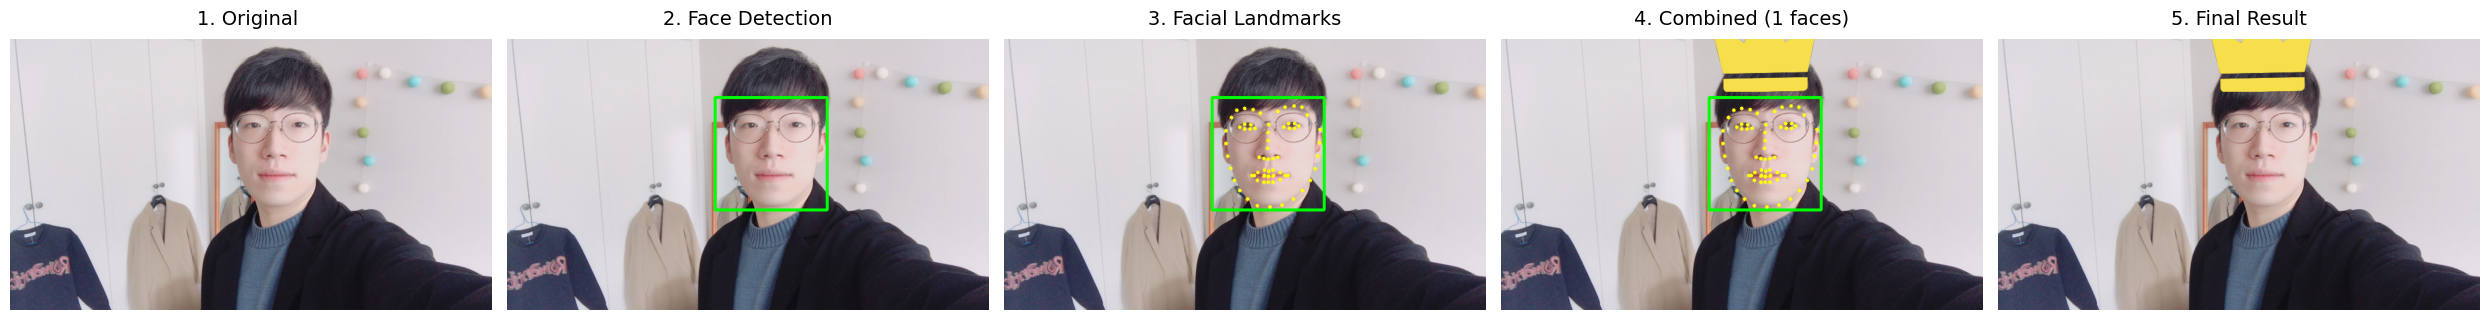

In [4]:
#왕관 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['king'])

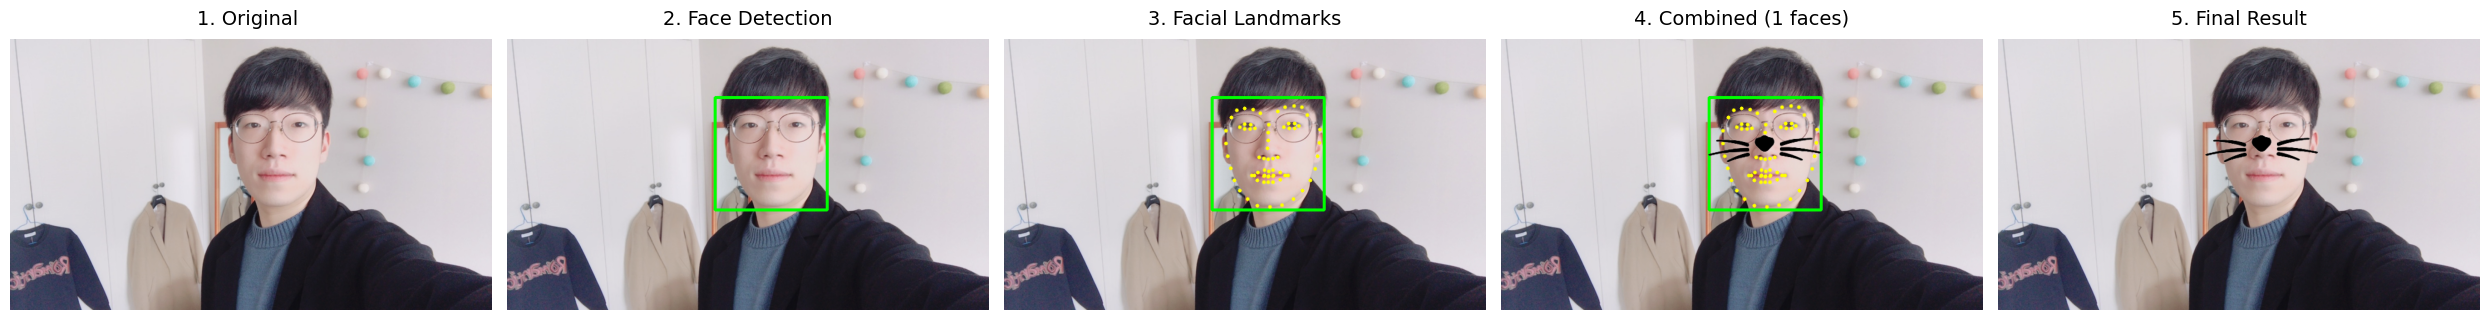

In [5]:
#고양이 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

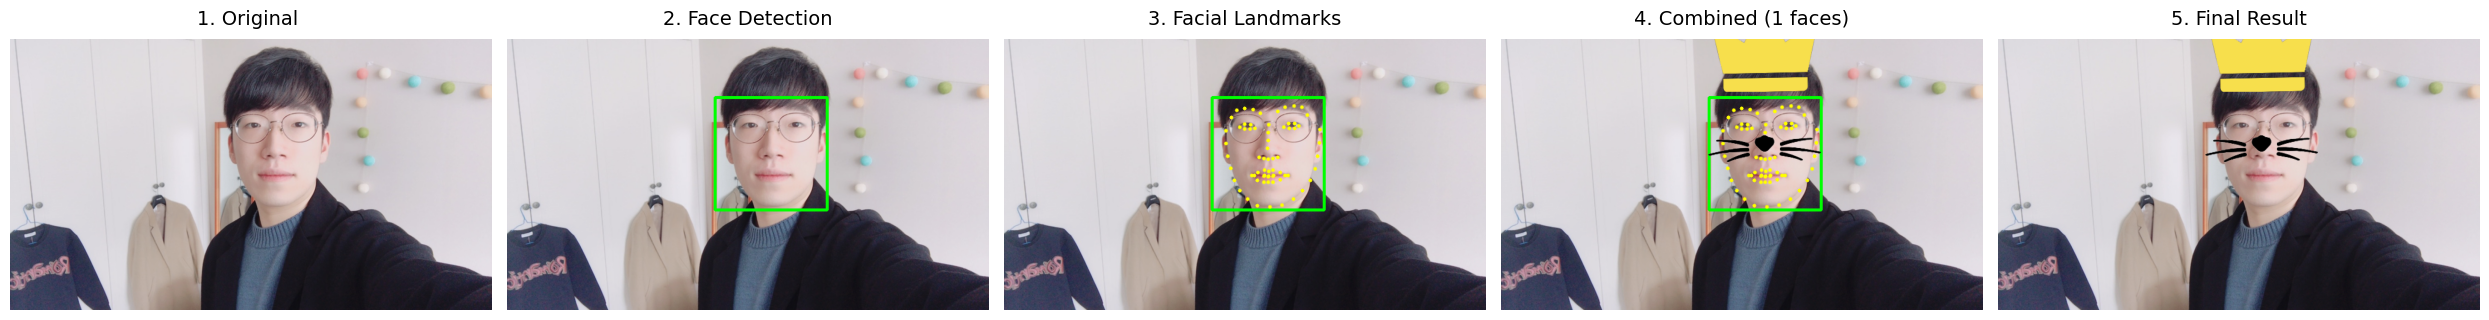

In [6]:
#고양이, 왕관 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king'])

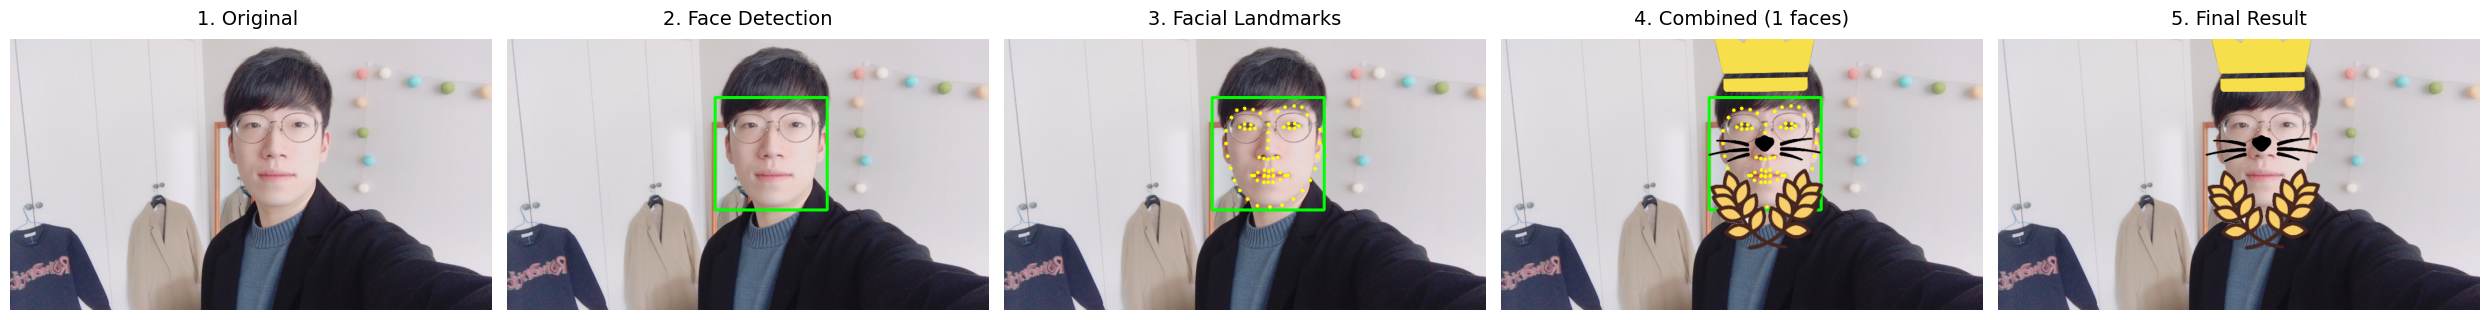

In [7]:
# 모든 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king','hero'])

각 과정을 단계별로 시각화하여 진행 상황을 한눈에 파악할 수 있도록 구성했습니다. (Step-by-Step Visualization)  
하나의 이모지를 적용할 수 있을 뿐만 아니라 여러 개의 이모지를 동시에 적용할 수 있게 구성했습니다. (Flexible Application) 

## 옆모습 탐지

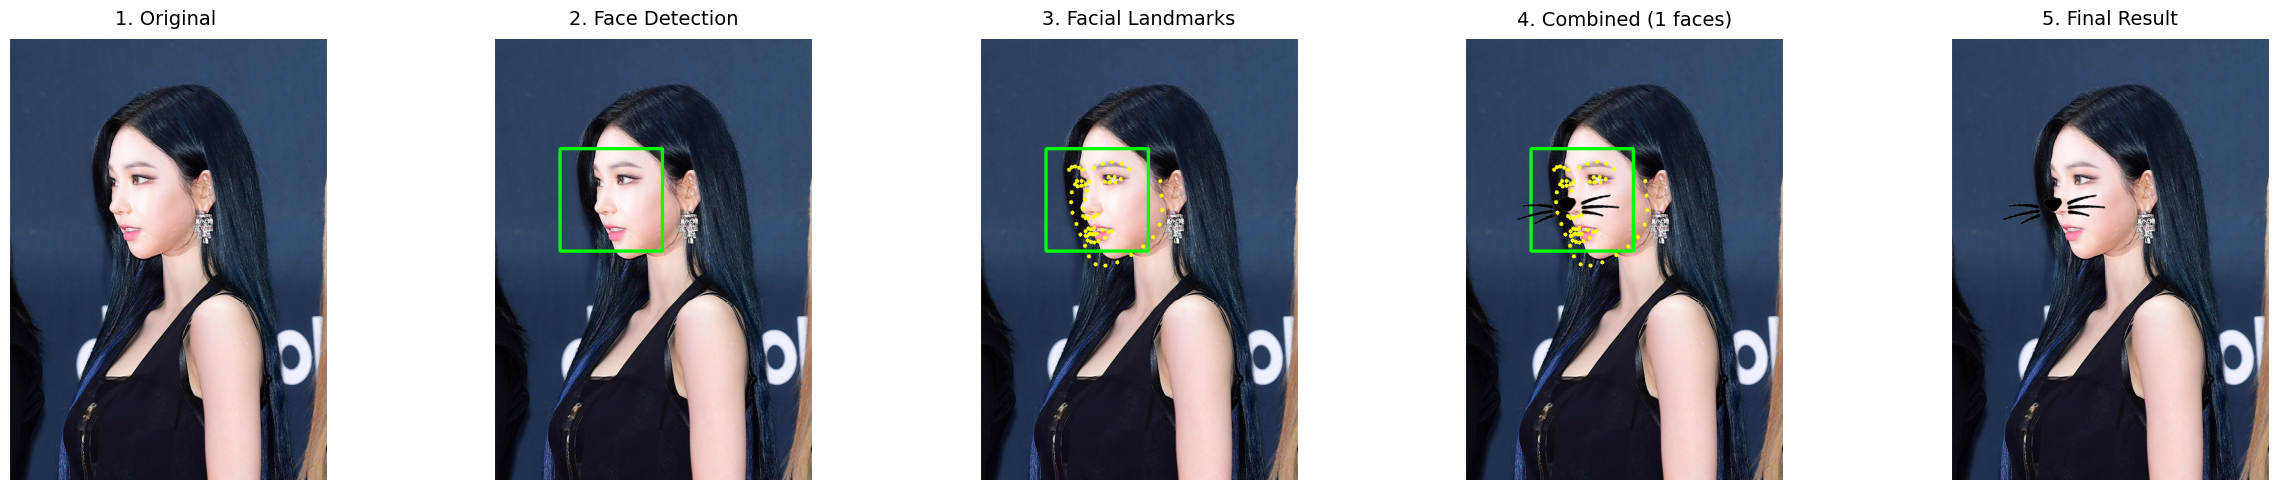

In [8]:
image_file = './images/karina4.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

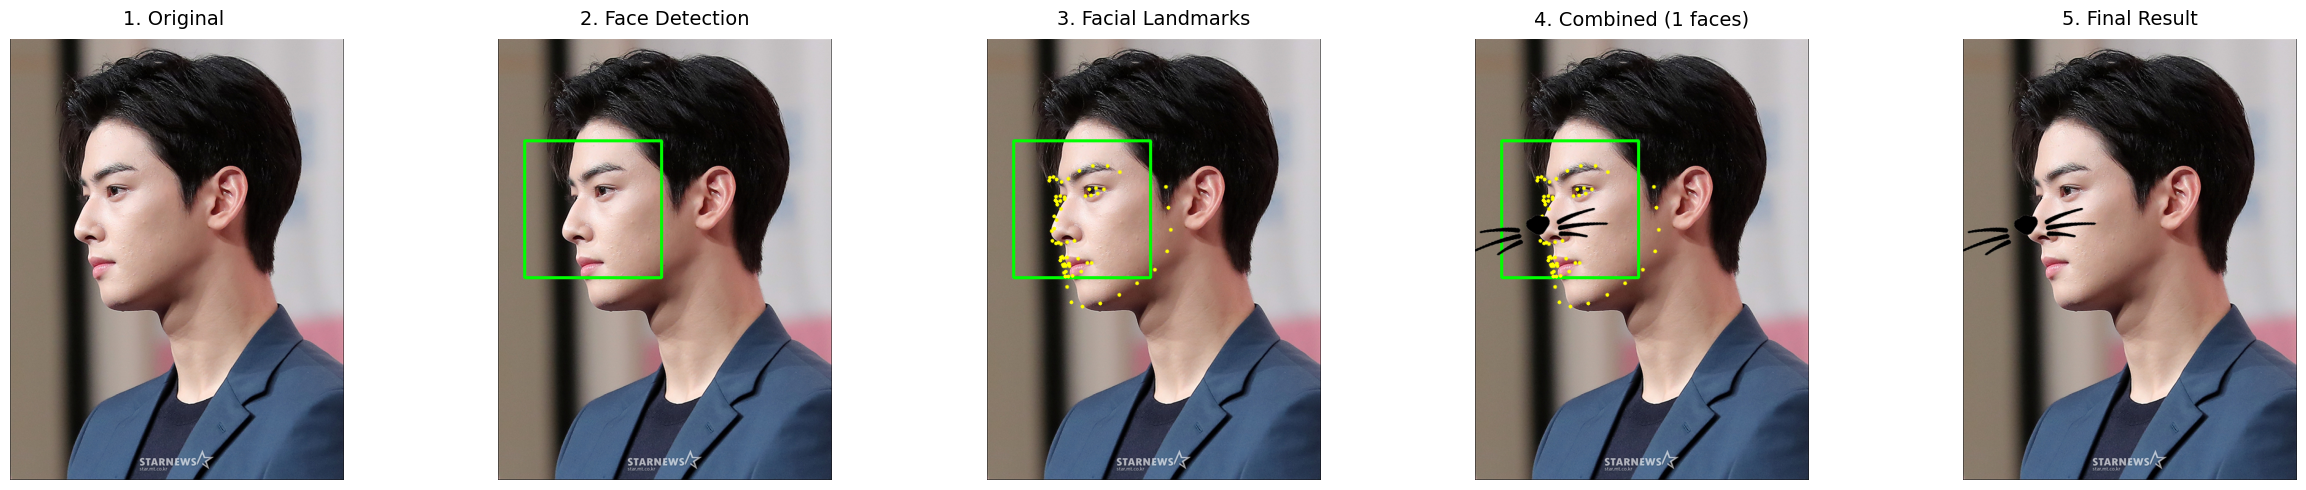

In [9]:
image_file = './images/eunwoo.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

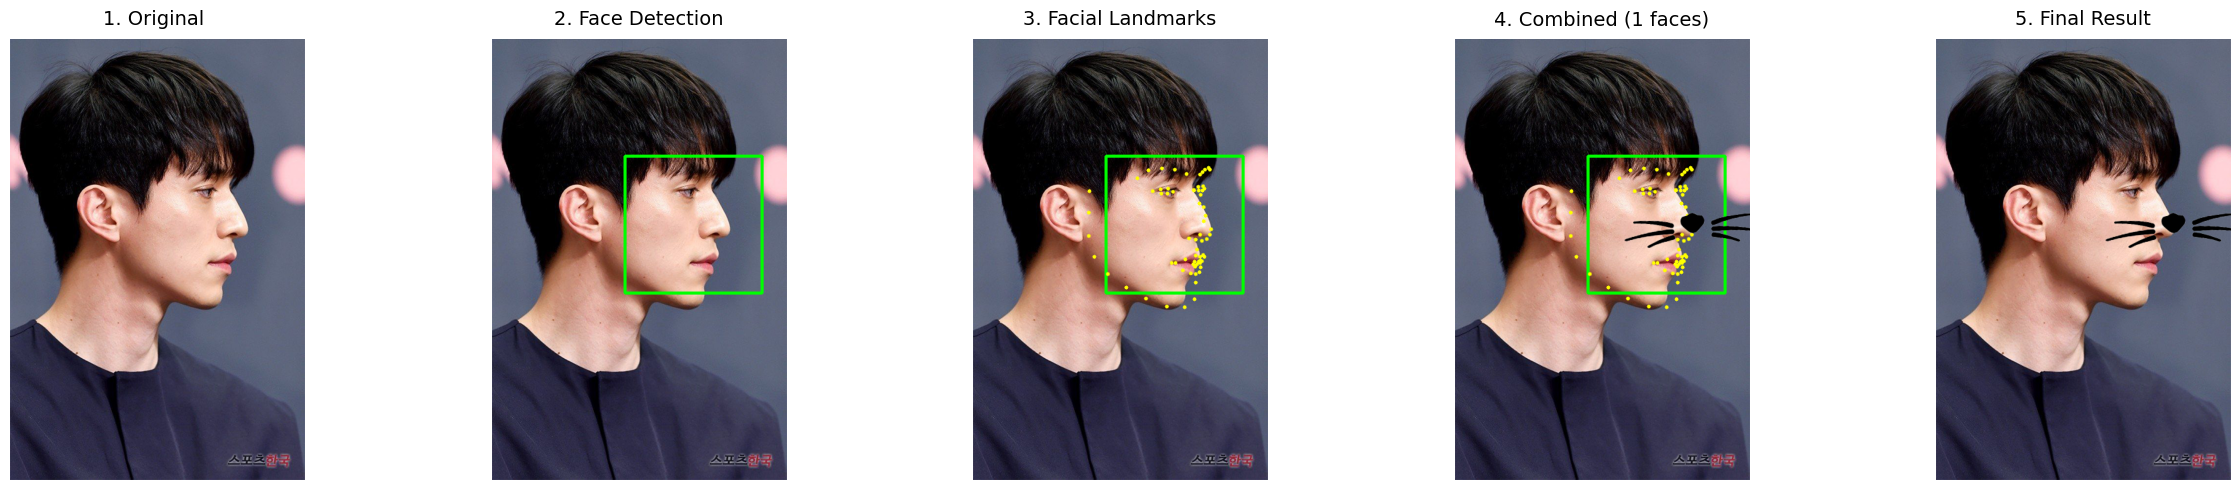

In [10]:
image_file = './images/dongwook.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

모델의 특징점을 기준으로 이모지를 적용합니다 (코끝[38], 턱선[8])  
양 눈의 기울기를 계산해 스티커를 회전하는 기능을 추가함으로써 자연스럽게 이모지가 합성될 수 있게 구성했습니다.

# 단체 사진

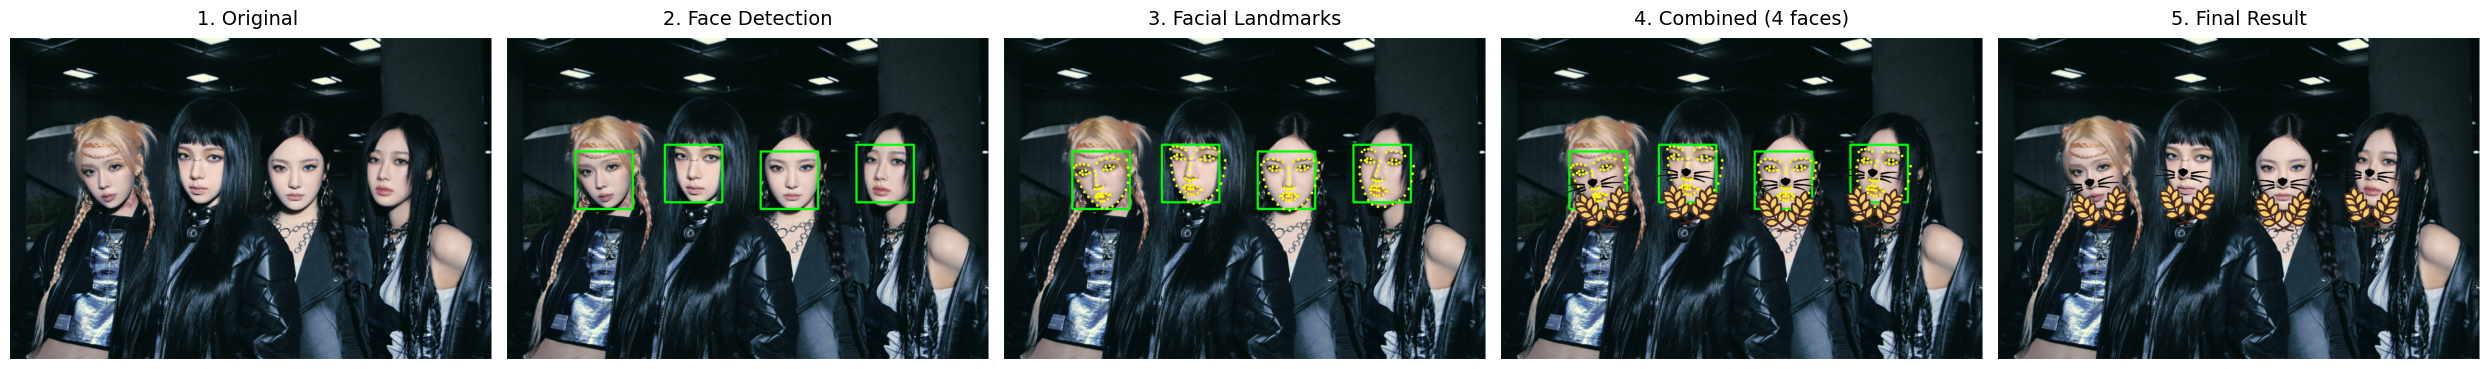

In [11]:
image_file = './images/aespa.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'hero'])

사진 내 여러명이 있을 경우 반복문을 사용해 탐지된 객체 모두에게 이모지를 적용할 수 있도록 구성했습니다  

## 애니메이션 캐릭터

In [12]:
image_file = './images/conan.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

얼굴을 찾을 수 없습니다.


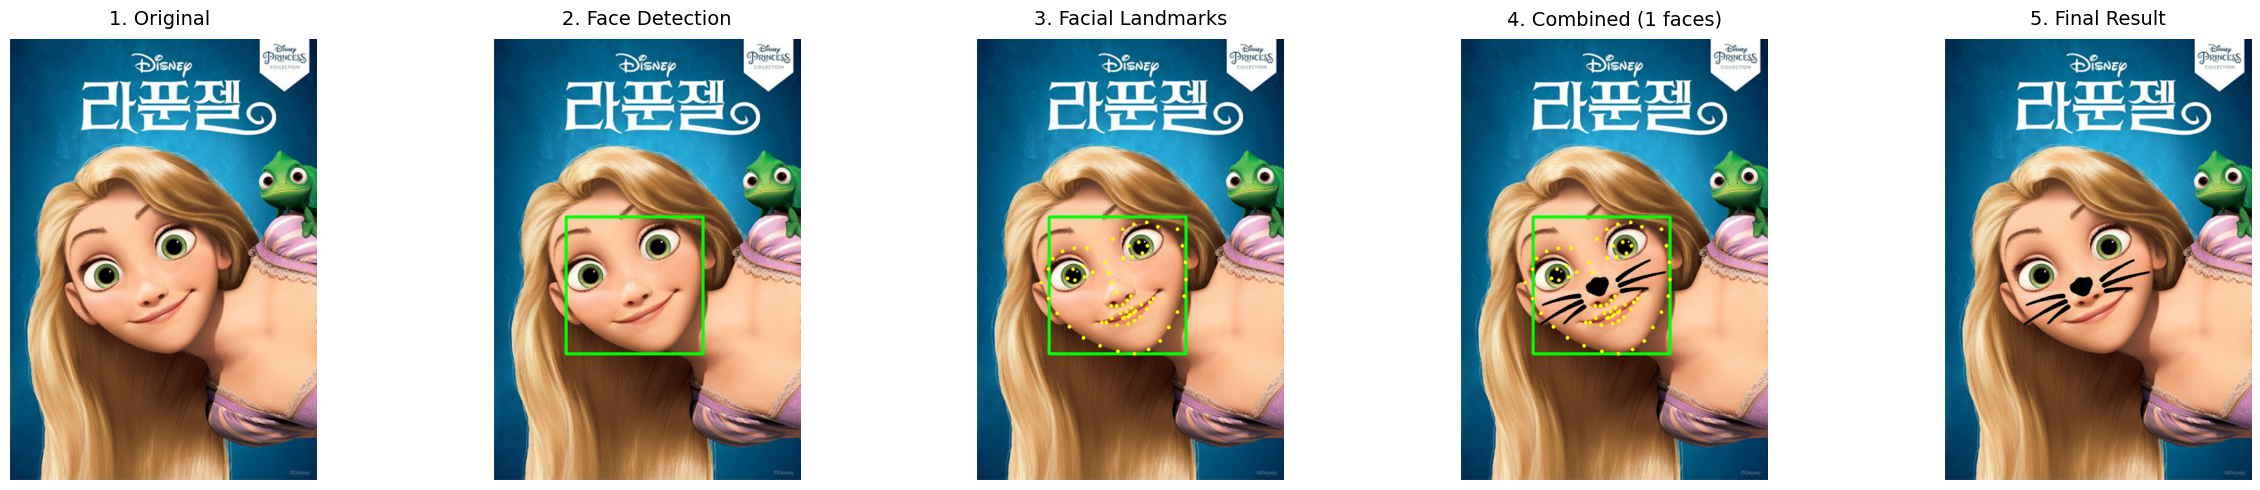

In [13]:
image_file = './images/Tangled.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

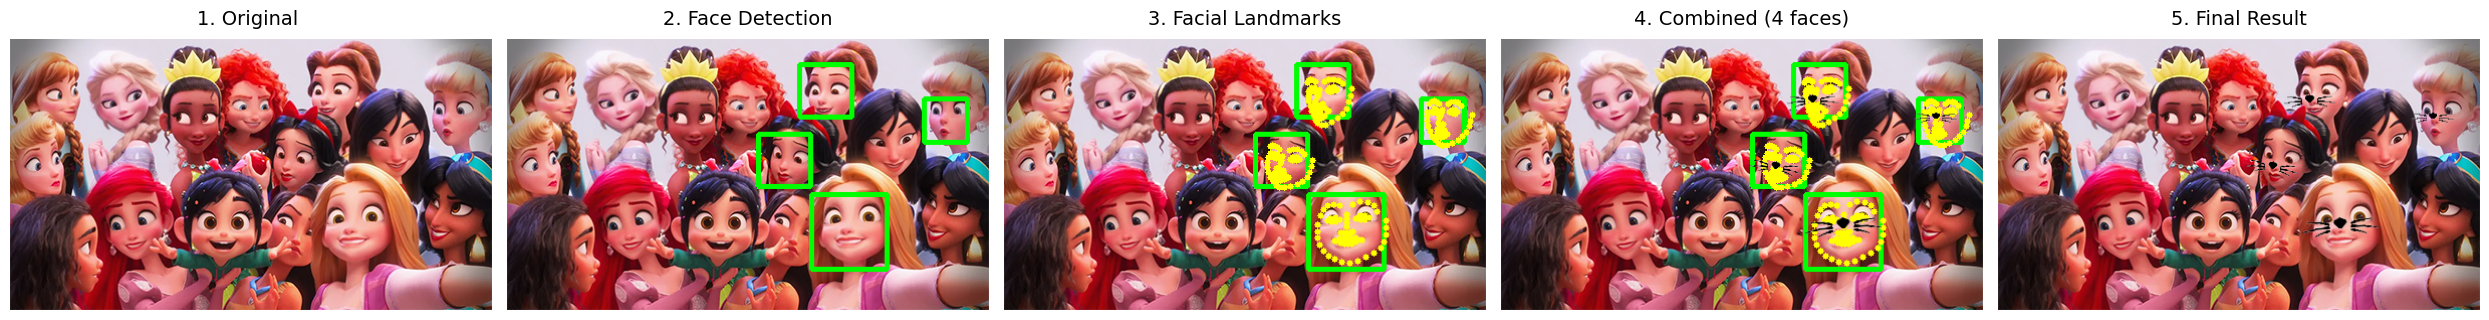

In [14]:
image_file = './images/disney.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

[애니메이션 캐릭터도 탐지할 수 있는 가]를 확인하기 위해 3장의 사진으로 test해본 결과
- 코난 이미지는 모델이 얼굴 특징을 탐지할 수 없었다 - 학습된 데이터와 크게 차이가 나는 이미지일 가능성이 높음
- 라푼젤 이미지는 모델이 얼굴 특징을 탐지할 수 있었다 - 그림체 뿐만 아니라 캐릭터의 외향으로 탐지가 가능한 것으로 보임
- 디즈니 캐릭터 단체 사진은 일부만 탐지할 수 있었다. - 이 점은 모델이 탐지할 수 있는게 조금 더 확인이 필요하다

## 게임 캐릭터

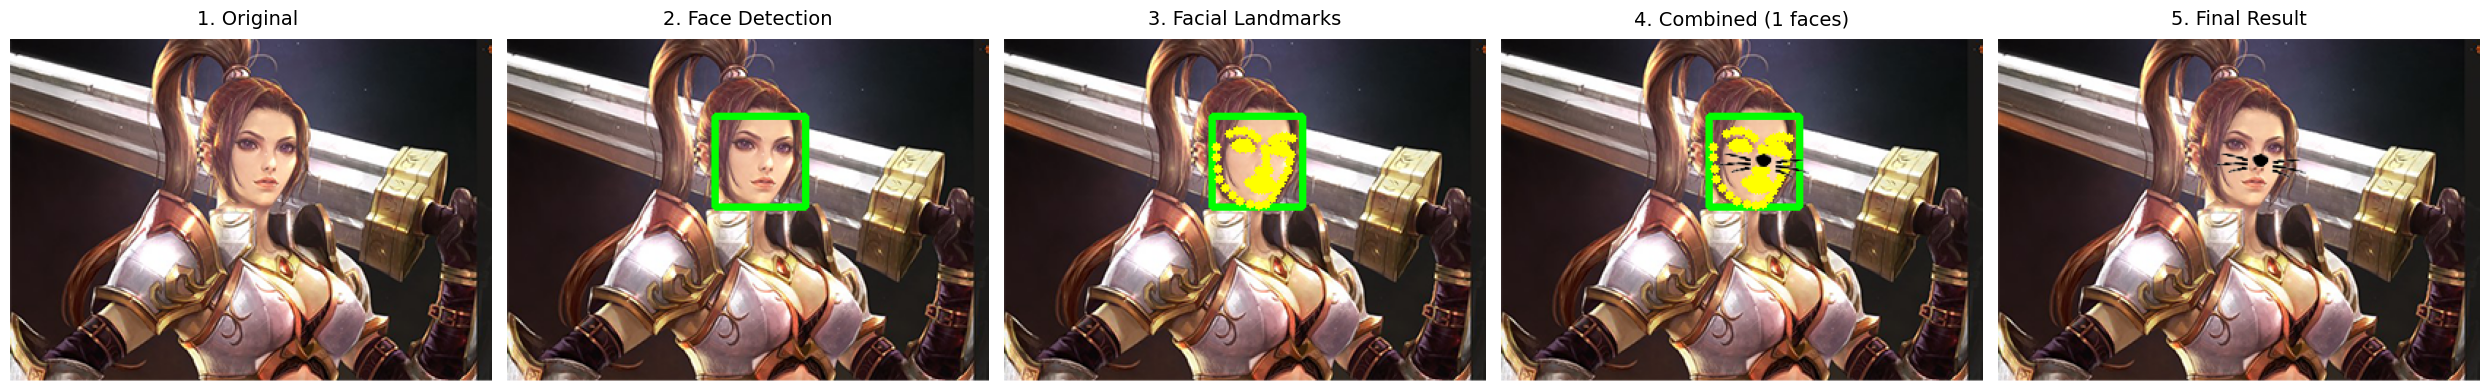

In [15]:
image_file = './images/lineage.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

In [16]:
image_file = './images/mario.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

얼굴을 찾을 수 없습니다.


[게임 캐릭터는 탐지할 수 있는가]를 확인하기 위해 2장의 사진으로 test해본 결과
- 리니지 게임 캐릭터는 모델이 얼굴 특징을 탐지할 수 있었다 - 실제 사람과 비슷하게 모델링되었기 때문에 탐지할 수 있는 것으로 보임
- 마리오 캐릭터는 모델이 얼굴 특징을 탐지할 수 없었다 - 게임 외형 때문인지는 모델의 성능 때문인지 조금 더 확인이 필요하다 

# 사진 각도

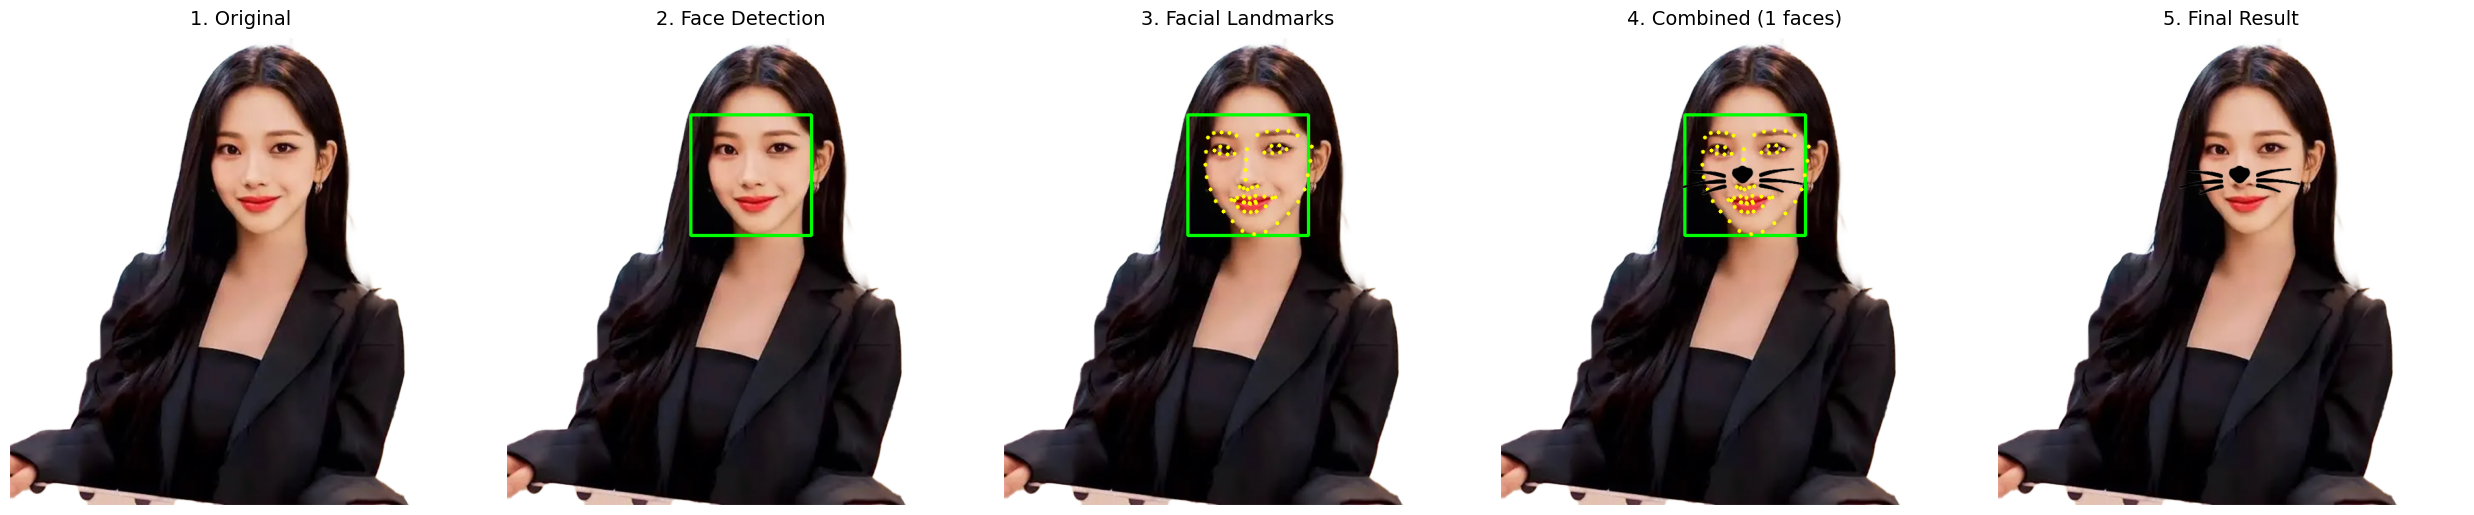

In [17]:
image_file = './images/karina1.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

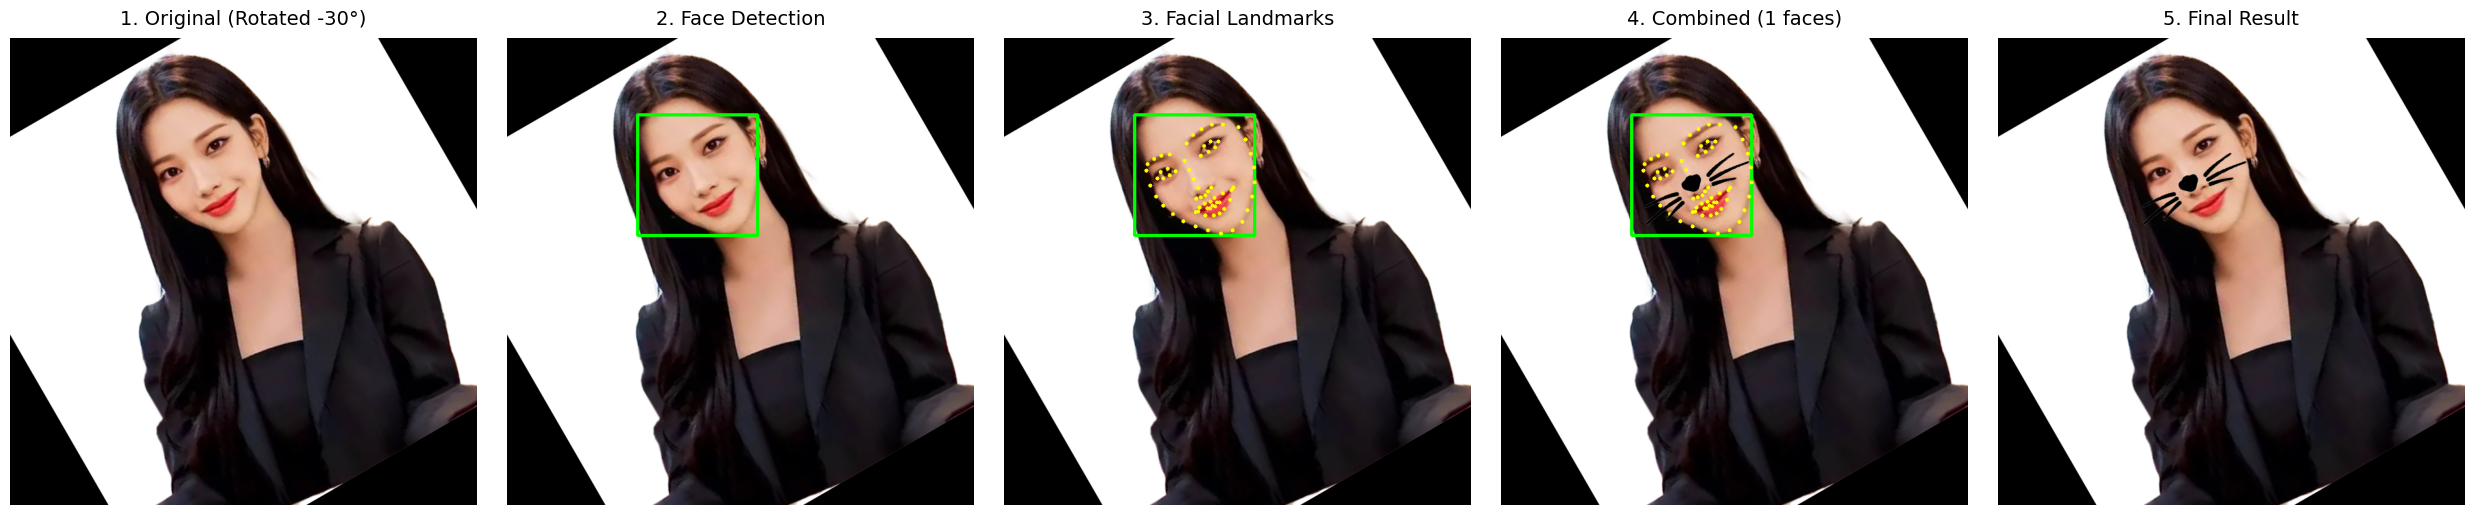

In [18]:
image_file = './images/karina1.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=-30)

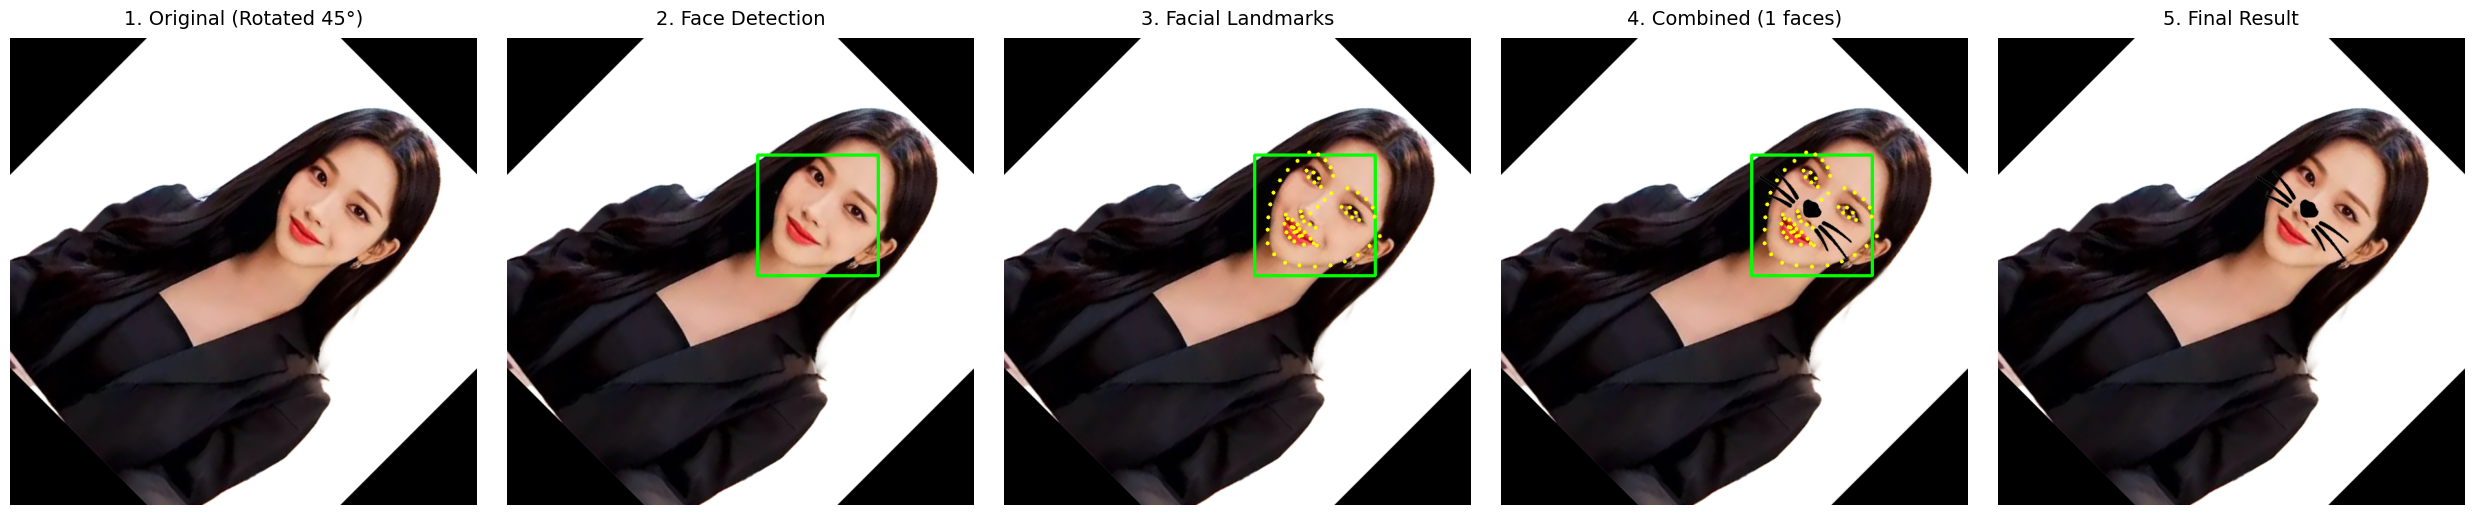

In [19]:
image_file = './images/karina1.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=45)

In [20]:
image_file = './images/karina1.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=90)

얼굴을 찾을 수 없습니다.


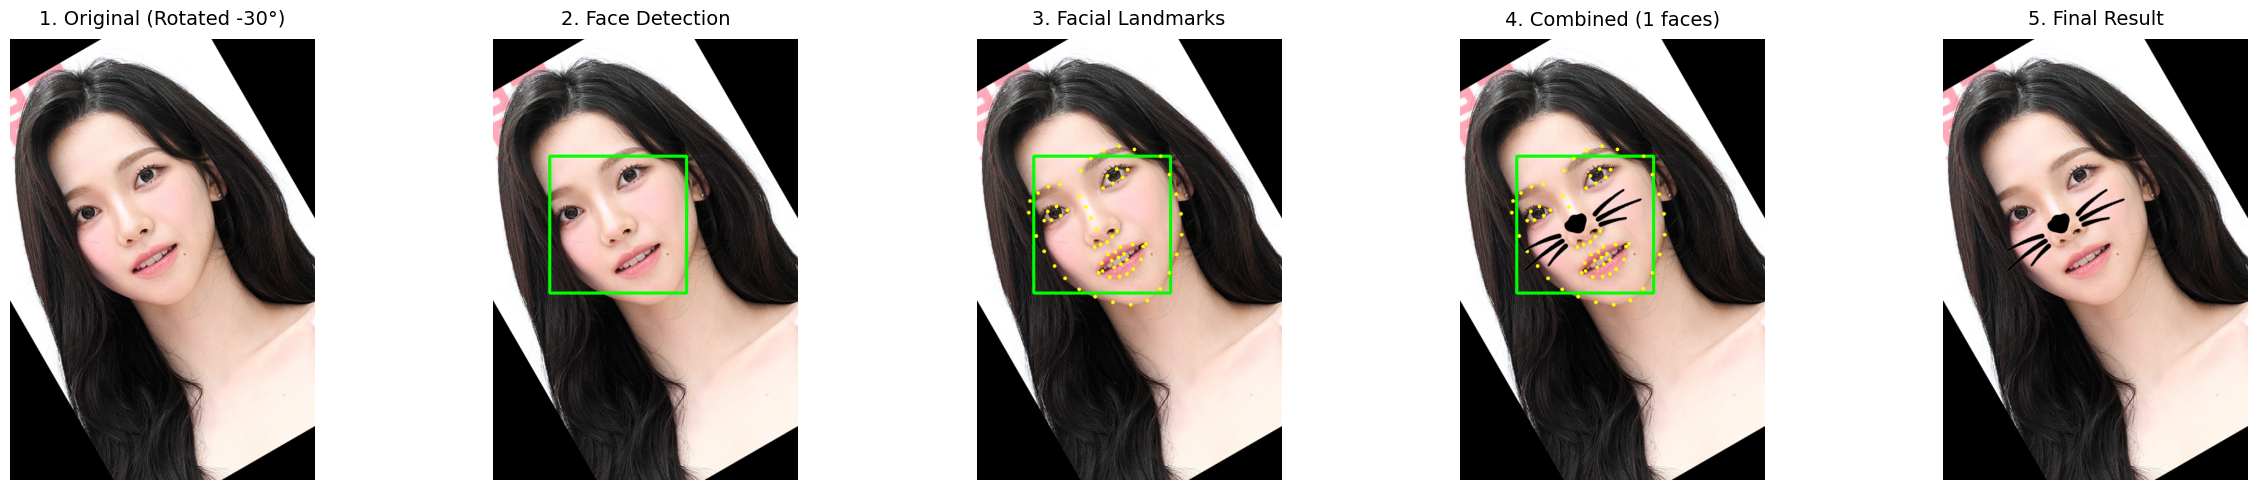

In [21]:
image_file = './images/karina2.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=-30)

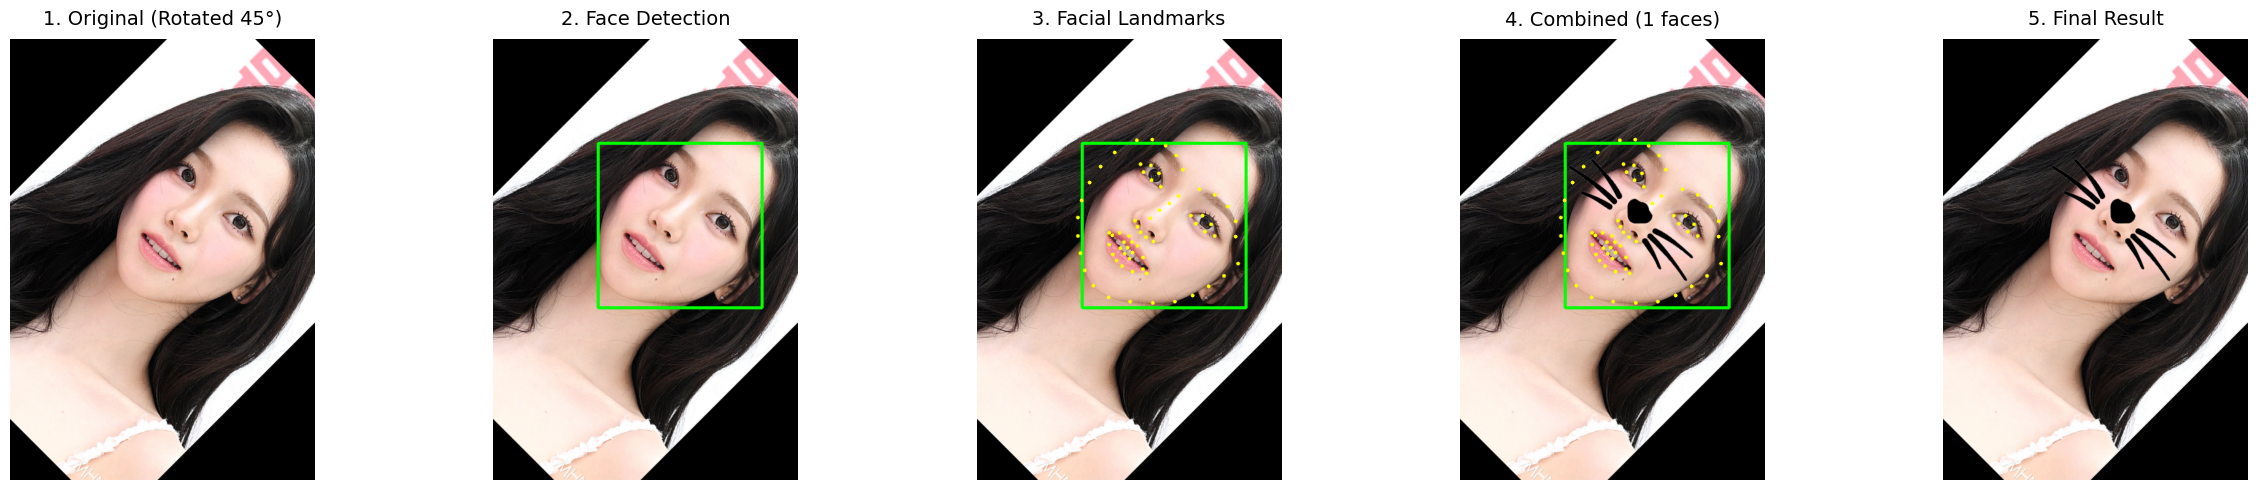

In [22]:
image_file = './images/karina2.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=45)

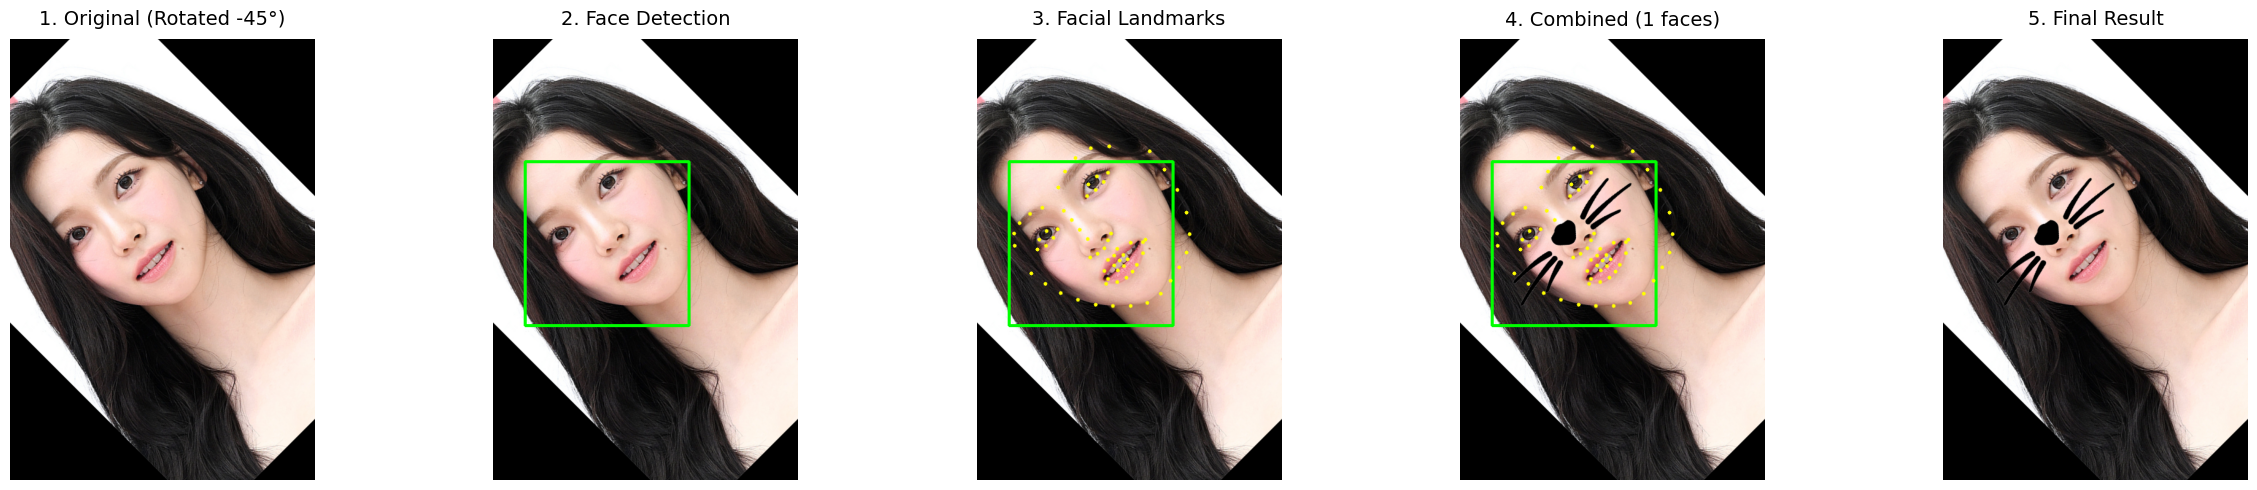

In [23]:
image_file = './images/karina2.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=-45)

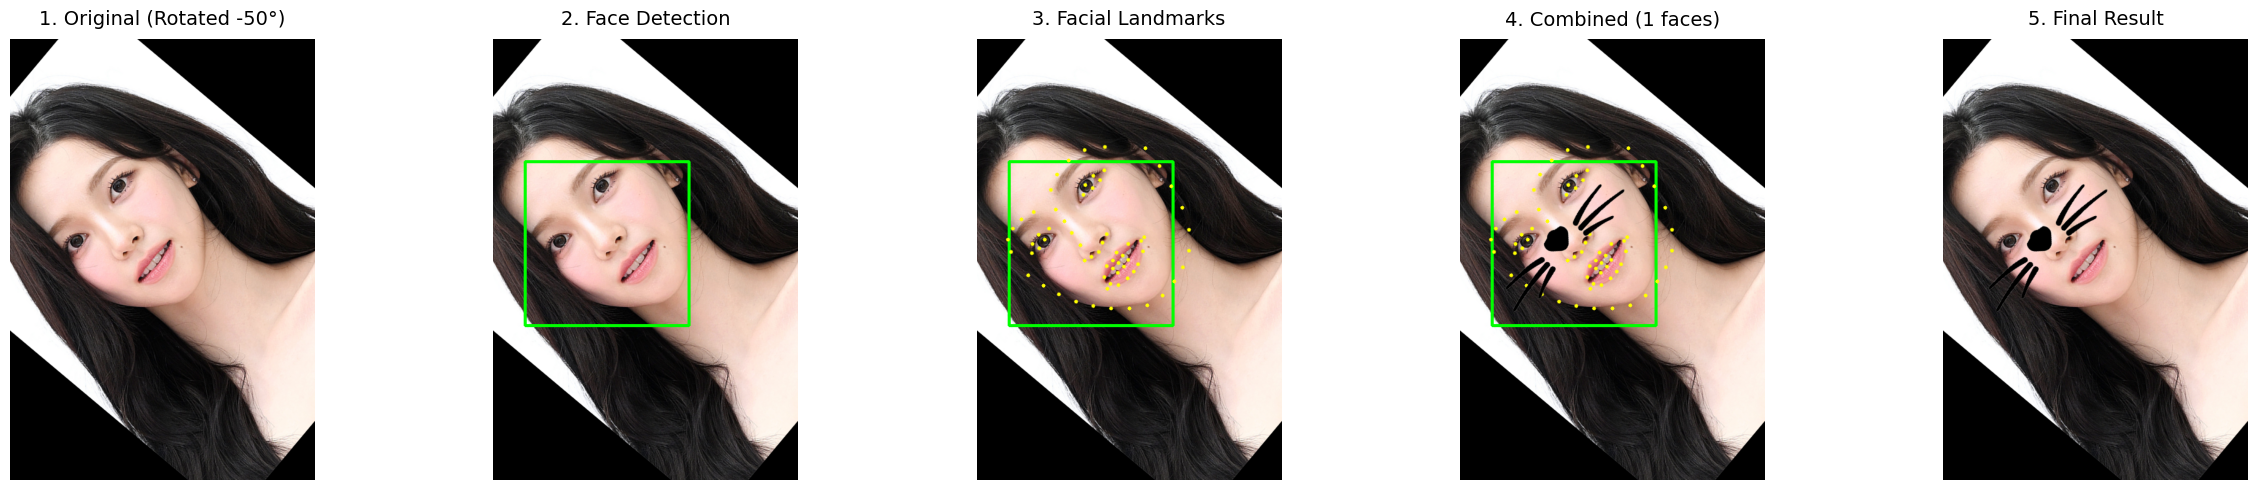

In [28]:
image_file = './images/karina2.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'], rotation_angle=-50)

사진의 각도에 따라 얼굴에 이모지를 적용할 수 있는가를 확인하기 위해 test를 해본 결과
- 이미지에 따라 50까지는 회전해도 이모지를 적용할 수 있는 것으로 확인했다.
- 양쪽 눈이 모델이 감지할 수 있다면 스티커를 회전시켜 자연스럽게 적용할 수 있다는 것도 확인할 수 있다. 